In [ ]:
#@title
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Project 1: Predict The World Population in 2100

#### Predicting the population is an interesting problem because of the amount of variables that go into population growth or decline. When building a model to predict this there are a few factors we thought would be the most important. Namely how much a population is growing and the cap of a population based off resources.

## Exploratory Data Analysis

### Top 5 Populations

In [ ]:
#@title
#Population since 1800s

pop = pd.read_csv("/content/gdrive/MyDrive/Applied Machine Learning/population-since-1800.csv", sep= ',')
pop = pop[pop['Code'].notnull()]
pop = pop[pop['Entity'] != 'World']
pop = pop.rename(columns={'Population (historical estimates)': 'Population'})
pop = pop[pop['Year'] < 2020]

avg = pop.groupby(['Entity']).mean()
avg = avg.sort_values(by='Population', ascending = False)

top5 = avg.head()
top5 = list(top5.index)

pop_top5 = pop[pop['Entity'].isin(top5)]
fig = px.line(pop_top5, x='Year', y='Population', line_group = 'Entity', title='Top 5 Populations', color = 'Entity')
fig.show()

## World Population

In [ ]:
#@title
pop = pd.read_csv('/content/gdrive/MyDrive/Applied Machine Learning/population-since-1800.csv')
pop = pop[pop['Entity']== 'World']
pop = pop.drop(['Code', 'Entity'], axis=1)
pop = pop[pop['Year']>=1961]
pop = pop.reset_index(drop=True)
fig = px.line(pop, x="Year", y="Population (historical estimates)", title='World Population over Time')
fig.show()
pop.shape

(61, 2)

In [ ]:
#@title
growth=pd.DataFrame()
growth['Year']=pop['Year']
growth['Percent Change']=pop['Population (historical estimates)'].pct_change()

## Percent Change of Population

In [ ]:
#@title
fig = px.line(growth, x="Year", y="Percent Change", title='Percent Change of World Population over Time')
fig.show()
pop.shape

(61, 2)

## Agricultural Land Use

In [ ]:
#@title
# sum of cropland and pasture for livestock grazing.
# measured in Hectare 
land = pd.read_csv('/content/gdrive/MyDrive/Applied Machine Learning/agricultural-land.csv')
land = land[land['Entity']== 'World']
land = land.drop(['Code', 'Entity'], axis=1)
land = land.reset_index(drop=True)
fig = px.line(land, x="Year", y="agricultural_land", title='Agriculture Land use')
fig.show()
land.shape

(58, 2)

## Correlation between Land Use and Population

In [ ]:
#@title
from plotly.subplots import make_subplots
import plotly.graph_objects as go

combine = pd.concat([pop, land], axis=1)
joined = pop.join(land, lsuffix='_pop', rsuffix='_land')
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=pop['Year'], y=pop['Population (historical estimates)'], name="Total Pop"),
    secondary_y=False)
fig.add_trace(
    go.Scatter(x=land['Year'], y=land['agricultural_land'], name="Amount of Agriculture Land Use"),
    secondary_y=True,)
fig.update_xaxes(title_text="Years")
fig.update_layout(title_text="Total Population vs Total Amount of Agricultural Land")
fig.update_yaxes(title_text="<b>Total Pop</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Total Land Use</b> (ha)", secondary_y=True)

In [ ]:
#@title
correlation=pop['Population (historical estimates)'][0:58].corr(land['agricultural_land'])
print(f"Correlation: {correlation}")

Correlation: 0.8663242987874986


Above we can see a plot that shows both population and land use. These things are fairly correlated at 86%, so land use seems to be a good limiting factor for our model because it is correlated with population and is finite, so it has to run out at some point.

According to the World Bank, we are currently using 11% of the world's landmass for agriculture, but we are using almost 50% of the total arable land for agriculture. While it may seem like we have a lot of lands to expand into, most of this land is either forested, protected, or settled. Removing this type of land we really have only 3% more arable land to expand into.

According to the FAO, the minimum amount of land to support one human being is .5 hectares of land. This figure assumes people are on a normal American and European diet, but this number would go down if everyone became vegetarian. The FAO estimates that we have at most 2.7 billion hectares left for crop production. Using this information we can estimate a carrying capacity for a model. A carrying capacity is a max number a population can reach before environmental degradation happens. If we add the 2.7 billion projected hectares remaining for agriculture to the 4.8 billion we currently use, we would have 7.5 billion hectares of usable farmland on Earth. Since each person requires about .5 of a hectare to be fed, the population capacity of the earth will be approximately 15 billion. 


## The Logisitic Growth Model

The Logistic Growth Model was initially created by Pierre-Francois Verhulst in 1838 as a way to model population growth. Verhulst explained an exponential population growth model would be an unrealistic model for a sufficiently large population due to limiting environmental factors. He formulated a logistic growth equation that would take these limiting factors into account.<br><br>
In his equation, the growth rate of a population is dependent on the size of the population, instead of being constant. As the population increases, the growth rate decreases. The differential equation is as follows:<br><br>


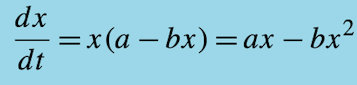

In this equation, the growth rate of population $x$ is $(a-bx)$, which is a function of population size. After solving the differential equation, it is clear that it evaluestes to the following equation when $x(0)≠0$:

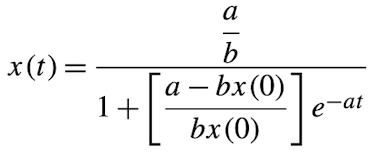

The meaning of the constants in this equation is as follows:<br>
1.   $a$ is the initial growth rate of the population
2.   $b$ is the decrease in growth rate per individual in the population
3.   $x(0)$ is the initial population then time is 0


$\frac{a}{b}$ is an important value in this model because it represents the largest population that the environment can sustain without a decrease in population. This is our 15 billion carrying capacity.<br><br>

For our model, we wanted to begin at the present day, so $a$ is the growth rate of the human population in 2021, and $x(0)$ is the population in 2021. The value of b was calculated from our carrying capacity of 15b: $\frac{a}{15} = b$ (All values were normalized to the billions for our model).


In [ ]:
#@title
#Population dynamics logistic growth equation
def logistic_growth_eq(init_year, proj_year, init_pop, carry_cap, init_g_rate):

  #b is the decrease in growth rate per individual
  b = init_g_rate/carry_cap
  numer = (init_g_rate - (b*init_pop))
  denom = b*init_pop
  exp = -(init_g_rate)*(proj_year-init_year)
  factor=math.exp(exp)

  population = carry_cap/(1+((numer/denom)*factor))

  return population

Below, you can see a graph of the historical population growth along with our model's prediction. In 2122, our model predicts that there will be 11.33 billion people. When observing the population growth rate over time, the trend reveals a general decrease, which provides some confidence in the accuracy of our model. <br><br>
Our model is highly dependent on the estimation for the carrying capacity on earth. Our model does not account for technological innovation that would increase agricultural efficiency because that is an unpredictable trend.
If some event were to drastically change human the human population with a sudden drop or boom, our model would also suffer. Our model assumes that none of these events happen, so in that case, it will be fairly accurate, but because of the randomness of world events, population predictions will change dramatically with the prevalence of new information.


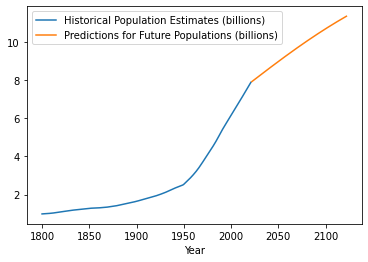

In [ ]:
#@title

from numpy.core.numeric import NaN


def growth_model(carrying_cap, hist_data, start_year, end_year):

  #normalizing historical data
  hist_data["Population (historical estimates)"] = hist_data["Population (historical estimates)"]/1000000000

  init_pop = hist_data["Population (historical estimates)"][start_year-1800]
  init_g_rate = (init_pop-hist_data["Population (historical estimates)"][start_year-1801])/init_pop
  
  predictions = pd.DataFrame({"Year": [i for i in range(start_year+1,end_year+1)],
                        #"Population (historical estimates)" : [NaN]*(end_year-(start_year+1)),
                        'Population (future prediction)': [logistic_growth_eq(start_year,j, init_pop, carrying_cap , init_g_rate) for j in range(start_year+1, end_year+1)]})
  
  
  return pd.concat([hist_data,predictions], ignore_index =True)


hist_pop = pd.read_csv('/content/gdrive/MyDrive/Applied Machine Learning/population-since-1800.csv')
hist_pop = hist_pop[hist_pop['Entity']== 'World']
hist_pop = hist_pop.drop(['Code', 'Entity'], axis=1)
#hist_pop = hist_pop[hist_pop['Year']>=1961]
hist_pop = hist_pop.reset_index(drop=True)

model = growth_model(15.000000000, hist_pop, 2021, 2122)


model.index = model.Year
model = model.drop(["Year"], axis=1)
model = model.rename({"Population (historical estimates)":"Historical Population Estimates (billions)", 'Population (future prediction)':"Predictions for Future Populations (billions)"}, axis='columns')
model.plot()

An inflection point is evident where the historical data ends and our prediction starts. This could be representative of current resistance to the effects of food constraints. This could be due to a large young population in areas where food is scarce. Unfortunately, the mortality rate is high in these areas and due to food constraints, a small percentage of the population makes it to adulthood. Other factors may also play into this resistance, but if our carrying capacity remains accurate, food supply and population size are highly correlated and our model should be accurate as time goes on.

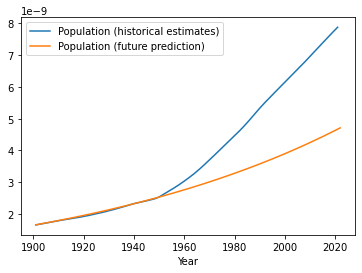

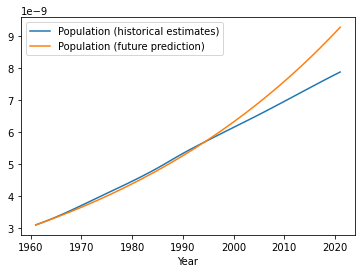

In [ ]:
#@title
model = growth_model(15.000000000, hist_pop, 1900, 2022)
model.index = model.Year
model = model.drop(["Year"], axis=1)
Accuracy=model[model.index>1900]
Accuracy.plot()

hist_pop["Population (historical estimates)"] = hist_pop["Population (historical estimates)"]*1000000000
model = growth_model(15.000000000, hist_pop, 1960, 2021)
model.index = model.Year
model = model.drop(["Year"], axis=1)
Accuracy=model[model.index>1960]
Accuracy.plot()


The above plots show the aforementioned flaw in our model. The prediction is highly dependent on the initial growth rate for its calculations and assumes that the growth rate will only decrease as time goes on and the population increases.<br><br>
The above graphs show how our predictions correlate to historical data. The first graph starts our model in 1900 and predicts to present day. The second graph starts the model in 1960 and predicts to present day.<br><br>
The first model underpredicts our population size by a considerable margin. The historical data and our prediction deviate around 1950. This is during the time of the baby boomers when populations dramatically increased after WWII. The second model overpredicts the population because the initial growth rate was inflated; 1960 is a year with a historically high growth rate.


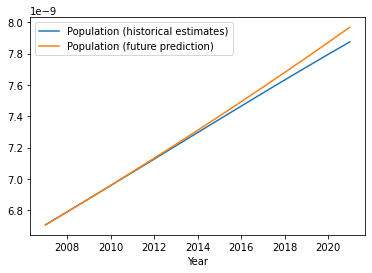

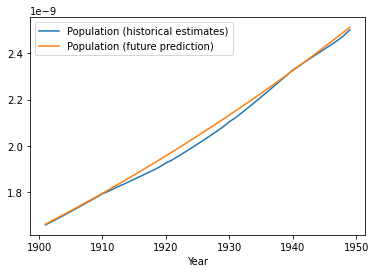

In [ ]:
#@title
hist_pop["Population (historical estimates)"] = hist_pop["Population (historical estimates)"]*1000000000
model = growth_model(15.000000000, hist_pop, 2006, 2021)
model.index = model.Year
model = model.drop(["Year"], axis=1)
Accuracy=model[model.index>2006]
Accuracy.plot()

hist_pop["Population (historical estimates)"] = hist_pop["Population (historical estimates)"]*1000000000
model = growth_model(15.000000000, hist_pop, 1900, 1950)
model.index = model.Year
model = model.drop(["Year"], axis=1)
Accuracy=model[model.index>1900]
Accuracy=Accuracy[Accuracy.index<1950]
Accuracy.plot()

It is clear from the above graph of our models are highly accurate for time spans in which there are little irregular fluctuations of population growth rate.

# Sources


1.   https://ourworldindata.org
2.   https://webpages.ciencias.ulisboa.pt/~mcgomes/aulas/dinpop/Mod13/Verhulst.pdf
3.   Stephen L. Campbell and Richard Haberman, Introduction to Differential Equations with 
Dynamical Systems, 2008. 


